In [1]:
import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from pdbbind_metadata_processor import PDBBindMetadataProcessor

In [2]:
pdbbind_table = PDBBindMetadataProcessor().get_master_dataframe()

In [3]:
pdbbind_table.head()

,PDB code,resolution,release year_x,-logKd/Ki,Kd/Ki,reference,ligand name,activity_list,sep,value,units,release year_y,Uniprot ID,protein name,active
0,3zzf,2.20,2012,0.40,Ki=400mM //,3zzf.pdf,(NLG),"[mM, =, 400]",=,400000000.0,nM,2012,Q01217,ACETYLGLUTAMATE KINASE,False
1,3gww,2.46,2009,0.45,IC50=355mM //,3gwu.pdf,(SFX),"[mM, =, 355]",=,355000000.0,nM,2009,O67854,TRANSPORTER,False
2,1w8l,1.80,2004,0.49,Ki=320mM //,1w8l.pdf,(1P3),"[mM, =, 320]",=,320000000.0,nM,2004,P62937,PEPTIDYL-PROLYL CIS-TRANS ISOMERASE A,False
3,3fqa,2.35,2009,0.49,IC50=320mM //,3fq7.pdf,(GAB&PMP),"[mM, =, 320]",=,320000000.0,nM,2009,P24630,"GLUTAMATE-1-SEMIALDEHYDE 2,1-AMINOMUTASE",False
4,1zsb,2.00,1996,0.60,Kd=250mM //,1zsb.pdf,(AZM),"[mM, =, 250]",=,250000000.0,nM,1996,P00918,CARBONIC ANHYDRASE 2,False


In [4]:
mol_results_path = 'results/protein_split_0_pdbbind/mol_results.p'
with open(mol_results_path, 'rb') as f :
    mol_results = pickle.load(f)

conf_results_path = 'results/protein_split_0_pdbbind/conf_results.p'
with open(conf_results_path, 'rb') as f :
    conf_results = pickle.load(f)

In [5]:
smiles_df = pd.read_csv('data/smiles_df.csv', index_col=0)

In [6]:
smiles_df.head()

,smiles,dataset,id,included
0,CC[C@H]1[C@@H](C(=O)N[C@]2(C(=O)NS(=O)(=O)C3(C...,pdbbind,6nzt,False
1,Cc1ccc(NC(=O)N[C@@H](Cc2cc(F)cc(F)c2)C(=O)N[C@...,pdbbind,6pka,False
2,O=c1ncc2c(-c3ccc(F)cc3F)cc(N3CC[NH2+]CC3)cc2n1...,pdbbind,1m7q,True
3,CC(C)C[C@H](NC(=O)[C@H](CC(N)=O)NC(=O)[C@@H](N...,pdbbind,5vwk,False
4,CC(C)C[C@H](NC(=O)[C@H](CC(N)=O)NC(=O)[C@@H](N...,pdbbind,5vwi,False


In [7]:
included_pdb_ids = smiles_df[(smiles_df['included']) & (smiles_df['dataset'] == 'pdbbind')]['id'].unique()

In [8]:
included_table = pdbbind_table[pdbbind_table['PDB code'].isin(included_pdb_ids)]

In [9]:
from chembl_connector import ChEMBLConnector
cc = ChEMBLConnector()
chembl_target_df = cc.get_target_table()
chembl_target_df.head()

,accession,component_synonym,protein_class_desc,second_level
0,O09028,Gabrp,ion channel lgic gabaa,ion channel lgic
1,P02708,CHRNA1,ion channel lgic ach chrn alpha,ion channel lgic
2,P04637,TP53,transcription factor,transcription factor
3,P04757,Chrna3,ion channel lgic ach chrn alpha,ion channel lgic
4,P05106,ITGB3,membrane receptor,membrane receptor


In [10]:
included_table = included_table.merge(chembl_target_df, left_on='Uniprot ID', right_on='accession')

In [19]:
included_table['second_level'].value_counts()[:5]

enzyme  kinase                  2785
enzyme  protease                1669
enzyme  transferase             1006
enzyme  hydrolase                866
epigenetic regulator  reader     643
Name: second_level, dtype: int64

In [13]:
def get_target_mol_results(uniprot_id) :
    all_results = {}
    target_pdb_ids = included_table[included_table['Uniprot ID'] == uniprot_id]['PDB code']
    ligand_smiles = smiles_df[smiles_df['id'].isin(target_pdb_ids)]['smiles'].unique()
    for smiles in ligand_smiles :
        if smiles in mol_results :
            all_results[smiles] = mol_results[smiles]
    return all_results

In [14]:
def group_target_results(all_results) :
    target_results = defaultdict(list)
    for smiles, result in all_results.items() :
        if 'normalized_first_bioactive_rank' in result :
            for key in result.keys() :
                value = result[key]
                if type(value) in [int, float, np.float64] :
                    target_results[key].append(value)
            normalized_first_bioactive_rank_model = result['normalized_first_bioactive_rank']['model']
            target_results['normalized_first_bioactive_rank_model'].append(normalized_first_bioactive_rank_model)
    return target_results

In [15]:
included_table[included_table['protein name'] == 'BETA-SECRETASE 1']

,PDB code,resolution,release year_x,-logKd/Ki,Kd/Ki,reference,ligand name,activity_list,sep,value,units,release year_y,Uniprot ID,protein name,active,accession,component_synonym,protein_class_desc,second_level
2046,4zsm,1.96,2015,2.40,IC50~4mM //,4zsm.pdf,(4RW),"[mM, ~, 4]",~,4000000.000,nM,2015,P56817,BETA-SECRETASE 1,False,P56817,BACE1,enzyme protease aspartic aa a1a,enzyme protease
2047,2ohk,2.20,2007,2.70,IC50~2000uM //,2ohk.pdf,(1SQ),"[uM, ~, 2000]",~,2000000.000,nM,2007,P56817,BETA-SECRETASE 1,False,P56817,BACE1,enzyme protease aspartic aa a1a,enzyme protease
2048,3bra,2.30,2008,2.70,Kd=2000uM //,3bra.pdf,(AEF),"[uM, =, 2000]",=,2000000.000,nM,2008,P56817,BETA-SECRETASE 1,False,P56817,BACE1,enzyme protease aspartic aa a1a,enzyme protease
2049,3hvg,2.26,2009,2.70,IC50=2mM //,3hvg.pdf,(EV0),"[mM, =, 2]",=,2000000.000,nM,2009,P56817,BETA-SECRETASE 1,False,P56817,BACE1,enzyme protease aspartic aa a1a,enzyme protease
2050,3udh,1.70,2012,2.85,Kd=1.4mM //,3udh.pdf,(091),"[mM, =, 1.4]",=,1400000.000,nM,2012,P56817,BETA-SECRETASE 1,False,P56817,BACE1,enzyme protease aspartic aa a1a,enzyme protease
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2366,6pz4,1.85,2019,9.40,IC50=0.0004uM //,6pz4.pdf,(P6J),"[uM, =, 0.0004]",=,0.400,nM,2019,P56817,BETA-SECRETASE 1,True,P56817,BACE1,enzyme protease aspartic aa a1a,enzyme protease
2367,5uyu,1.90,2017,9.51,IC50=0.31nM //,5uyu.pdf,(8QV),"[nM, =, 0.31]",=,0.310,nM,2017,P56817,BETA-SECRETASE 1,True,P56817,BACE1,enzyme protease aspartic aa a1a,enzyme protease
2368,2g94,1.86,2006,9.52,Ki=0.3nM //,2g94.pdf,(ZPQ),"[nM, =, 0.3]",=,0.300,nM,2006,P56817,BETA-SECRETASE 1,True,P56817,BACE1,enzyme protease aspartic aa a1a,enzyme protease
2369,4wtu,1.85,2015,9.52,IC50=0.3nM //,4wtu.pdf,(3UT),"[nM, =, 0.3]",=,0.300,nM,2015,P56817,BETA-SECRETASE 1,True,P56817,BACE1,enzyme protease aspartic aa a1a,enzyme protease


In [24]:
target_name = 'BETA-SECRETASE 1'
uniprot_id = 'P56817'
all_results = get_target_mol_results(uniprot_id)

In [25]:
len(all_results)

4

In [15]:
def get_target_name_from_uniprot_id(uniprot_id) :
    if uniprot_id in pdbbind_table['Uniprot ID'].values :
        return pdbbind_table[pdbbind_table['Uniprot ID'] == uniprot_id]['protein name'].value_counts().index[0]
    else :
        print('Uniprot not in PDBbind')
        return None

In [16]:
train_pdbs_path = 'data/protein_similarity_splits/train_pdb_protein_similarity_split_0.txt'
with open(train_pdbs_path, 'r') as f :
    train_pdbs = f.readlines()
    train_pdbs = [s.strip() for s in train_pdbs]
def get_training_size(uniprot_id) :
    filtered_table = pdbbind_table[(pdbbind_table['PDB code'].isin(train_pdbs)) & (pdbbind_table['Uniprot ID'] == uniprot_id)]
    return len(filtered_table)

In [18]:
target_grouped_results = defaultdict(list)
for uniprot_id in included_table['Uniprot ID'].unique() :
    
    all_results = get_target_mol_results(uniprot_id)
    target_results = group_target_results(all_results)
    
    if len(target_results) :

        ranks = target_results['normalized_first_bioactive_rank_model']
        median = np.median(ranks)
        n_first = len([True for rank in ranks if rank == 0])
        fraction_bioactive_first = n_first / len(ranks)
        target_name = get_target_name_from_uniprot_id(uniprot_id)
        training_set_size = get_training_size(uniprot_id)
        target_grouped_results['uniprot_id'].append(uniprot_id)
        target_grouped_results['name'].append(target_name)
        target_grouped_results['fraction_bio_first'].append(fraction_bioactive_first)
        target_grouped_results['training_set_size'].append(training_set_size)
        target_grouped_results['median_rank'].append(median)
        target_grouped_results['test_set_size'].append(len(ranks))

In [20]:
target_results

defaultdict(list,
            {'n_rotatable_bonds': [5],
             'n_heavy_atoms': [16],
             'max_sim_to_training': [1.0],
             'n_bioactive': [4],
             'n_generated': [100],
             'r2_all': [0.34264269677769266],
             'pearson_all': [0.6360579933730502],
             'spearman_all': [0.5941746021158206],
             'r2_gen': [0.43163364174923524],
             'pearson_gen': [0.693407276910914],
             'spearman_gen': [0.625082508250825],
             'normalized_first_bioactive_rank_model': [0.009615384615384616]})

In [22]:
target_df = pd.DataFrame(target_grouped_results)

In [23]:
target_df.sort_values('training_set_size')

,uniprot_id,name,fraction_bio_first,training_set_size,median_rank,test_set_size
427,Q9PTN2,VITAMIN D3 RECEPTOR A,0.500000,0,0.004950,8
176,D0VX21,BETA-HEXOSAMINIDASE,0.333333,0,0.048193,3
177,P58154,ACETYLCHOLINE-BINDING PROTEIN,0.050000,0,0.470297,20
406,Q9NYA1,SPHINGOSINE KINASE 1,0.000000,0,0.214286,3
405,P49841,GLYCOGEN SYNTHASE KINASE-3 BETA,0.138889,0,0.381188,36
...,...,...,...,...,...,...
12,P00760,TRYPSIN,1.000000,183,0.000000,3
40,O60885,BROMODOMAIN-CONTAINING PROTEIN 4,0.000000,192,0.469388,1
17,------,5'-METHYLTHIOADENOSINE/S-ADENOSYLHOMOCYSTEINE ...,0.312500,195,0.150563,32
76,P24941,CELL DIVISION PROTEIN KINASE 2,0.000000,240,0.683168,1


In [17]:
def get_target_mol_results(target_class) :
    all_results = {}
    target_pdb_ids = included_table[included_table['second_level'] == target_class]['PDB code']
    ligand_smiles = smiles_df[smiles_df['id'].isin(target_pdb_ids)]['smiles'].unique()
    for smiles in ligand_smiles :
        if smiles in mol_results :
            all_results[smiles] = mol_results[smiles]
    return all_results

In [22]:
def group_target_results(all_results) :
    target_results = defaultdict(list)
    for smiles, result in all_results.items() :
        if 'normalized_first_bioactive_rank' in result :
            for key in result.keys() :
                value = result[key]
                if type(value) in [int, float, np.float64] :
                    target_results[key].append(value)
            normalized_first_bioactive_rank_model = result['normalized_first_bioactive_rank']['model']
            target_results['normalized_first_bioactive_rank_model'].append(normalized_first_bioactive_rank_model)
    return target_results

In [25]:
train_pdbs_path = 'data/protein_similarity_splits/train_pdb_protein_similarity_split_0.txt'
with open(train_pdbs_path, 'r') as f :
    train_pdbs = f.readlines()
    train_pdbs = [s.strip() for s in train_pdbs]
def get_training_size(target_class) :
    filtered_table = included_table[(included_table['PDB code'].isin(train_pdbs)) & (included_table['second_level'] == target_class)]
    return len(filtered_table)

In [26]:
target_grouped_results = defaultdict(list)
for target_class in included_table['second_level'].unique() :
    
    all_results = get_target_mol_results(target_class)
    target_results = group_target_results(all_results)
    
    if len(target_results) :

        ranks = target_results['normalized_first_bioactive_rank_model']
        median = np.median(ranks)
        n_first = len([True for rank in ranks if rank == 0])
        fraction_bioactive_first = n_first / len(ranks)
        training_set_size = get_training_size(target_class)
        target_grouped_results['target_class'].append(target_class)
        target_grouped_results['fraction_bio_first'].append(fraction_bioactive_first)
        target_grouped_results['training_set_size'].append(training_set_size)
        target_grouped_results['median_rank'].append(median)
        target_grouped_results['test_set_size'].append(len(ranks))

In [27]:
target_df = pd.DataFrame(target_grouped_results)

In [29]:
target_df.sort_values('training_set_size', ascending=False)

,target_class,fraction_bio_first,training_set_size,median_rank,test_set_size
5,enzyme kinase,0.166667,2317,0.277228,138
1,enzyme protease,0.114504,1204,0.267327,131
7,enzyme transferase,0.203390,801,0.141176,59
8,epigenetic regulator reader,0.105263,603,0.455446,19
4,enzyme hydrolase,0.135135,575,0.316832,111
14,cytosolic other,0.250000,412,0.158416,4
13,enzyme,0.451613,409,0.011236,31
15,transcription factor nuclear receptor,0.285714,297,0.217822,35
11,enzyme phosphodiesterase,1.000000,283,0.000000,1
6,unclassified,0.272727,261,0.256098,33


In [117]:
target_df['name']

0                     ACETYLGLUTAMATE KINASE
1                                TRANSPORTER
2      PEPTIDYL-PROLYL CIS-TRANS ISOMERASE A
3                       CARBONIC ANHYDRASE 2
4                  METHIONINE AMINOPEPTIDASE
                       ...                  
965                           NL4-3 PROTEASE
966         PUTATIVE UNCHARACTERIZED PROTEIN
967          ANTIBODY FAB ADD056 HEAVY CHAIN
968                             GLUCOAMYLASE
969                                XENAVIDIN
Name: name, Length: 970, dtype: object

In [36]:
xenavidin_uniprot = target_df[target_df['name'] == 'XENAVIDIN']['uniprot_id'].values[0]

In [40]:
included_table[included_table['Uniprot ID'] == xenavidin_uniprot]

,PDB code,resolution,release year_x,-logKd/Ki,Kd/Ki,reference,ligand name,activity_list,sep,value,units,release year_y,Uniprot ID,protein name,active
19433,2uyw,1.70,2008 1,3.0,Kd=0.1pM //,2uyw.pdf,(BTN),"[pM, =, 0.1]",=,0.0001,nM,2008,A7YYL1,XENAVIDIN,True


In [41]:
'2uyw' in train_pdbs

True

In [37]:
xenavidin_pdb = included_table[included_table['Uniprot ID'] == xenavidin_uniprot]['PDB code'].values[0]

In [38]:
xenavidin_smiles = smiles_df[smiles_df['id'] == xenavidin_pdb]['smiles'].values[0]

In [39]:
xenavidin_smiles

'O=C([O-])CCCC[C@@H]1SC[C@@H]2NC(=O)N[C@H]12'

In [135]:
val_smiles_path = 'data/ligand_random_splits/val_smiles_random_split_0.txt'
with open(train_smiles_path, 'r') as f :
    val_smiles = f.readlines()
    val_smiles = [smiles.strip() for smiles in val_smiles]

In [133]:
test_smiles_path = 'data/ligand_random_splits/test_smiles_random_split_0.txt'
with open(train_smiles_path, 'r') as f :
    test_smiles = f.readlines()
    test_smiles = [smiles.strip() for smiles in test_smiles]

In [136]:
xenavidin_smiles in val_smiles

True

<AxesSubplot:xlabel='training_set_size', ylabel='fraction_bio_first'>

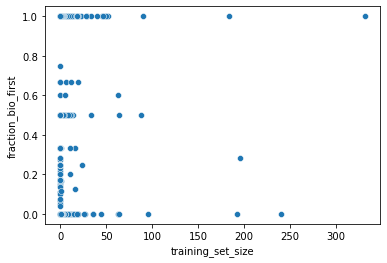

In [43]:
sns.scatterplot(data=target_df, x='training_set_size', y='fraction_bio_first')